# Estimate scavenging rates from observations

Dissolved trace metal data from Manuel Colombo, particulate trace metal data from Jingxuan Li.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
import warnings
import seaborn as sns; sns.set()
import netCDF4 as nc
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
from scipy.signal import savgol_filter

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar

##### Load files:

In [8]:
Pb_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')

In [9]:
# Particulate trace metal observations:
p_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/pTM_Maldonado_DATA_v2_notes.csv')

stns = p_data['GEOTR_STN'].astype('str')
pPb_BB1 = p_data['Pb (pmol/L)'].where(stns == 'BB1').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_BB2 = p_data['Pb (pmol/L)'].where(stns == 'BB2').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_BB3 = p_data['Pb (pmol/L)'].where(stns == 'BB3').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_CB1 = p_data['Pb (pmol/L)'].where(stns == 'CB1').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_CB2 = p_data['Pb (pmol/L)'].where(stns == 'CB2').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_CB3 = p_data['Pb (pmol/L)'].where(stns == 'CB3').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_CB4 = p_data['Pb (pmol/L)'].where(stns == 'CB4').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_CAA1 = p_data['Pb (pmol/L)'].where(stns == 'CAA1').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_CAA2 = p_data['Pb (pmol/L)'].where(stns == 'CAA2').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_CAA3 = p_data['Pb (pmol/L)'].where(stns == 'CAA3').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_CAA4 = p_data['Pb (pmol/L)'].where(stns == 'CAA4').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_CAA5 = p_data['Pb (pmol/L)'].where(stns == 'CAA5').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_CAA6 = p_data['Pb (pmol/L)'].where(stns == 'CAA6').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_CAA7 = p_data['Pb (pmol/L)'].where(stns == 'CAA7').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_CAA8 = p_data['Pb (pmol/L)'].where(stns == 'CAA8').apply(pd.to_numeric, errors='coerce').dropna().astype('float')
pPb_CAA9 = p_data['Pb (pmol/L)'].where(stns == 'CAA9').apply(pd.to_numeric, errors='coerce').dropna().astype('float')

pd_BB1     = p_data['CTDPRS (DBAR)'].where(stns == 'BB1').dropna().astype('float')
pd_BB2     = p_data['CTDPRS (DBAR)'].where(stns == 'BB2').dropna().astype('float')
pd_BB3     = p_data['CTDPRS (DBAR)'].where(stns == 'BB3').dropna().astype('float')
pdepth_BB1 = [pd_BB1[i] for i in pPb_BB1.index.values]; pdepth_BB2 = [pd_BB2[i] for i in pPb_BB2.index.values]; 
pdepth_BB3 = [pd_BB3[i] for i in pPb_BB3.index.values];

pd_CB1     = p_data['CTDPRS (DBAR)'].where(stns == 'CB1').dropna().astype('float')
pd_CB2     = p_data['CTDPRS (DBAR)'].where(stns == 'CB2').dropna().astype('float')
pd_CB3     = p_data['CTDPRS (DBAR)'].where(stns == 'CB3').dropna().astype('float')
pd_CB4     = p_data['CTDPRS (DBAR)'].where(stns == 'CB4').dropna().astype('float')
pdepth_CB1 = [pd_CB1[i] for i in pPb_CB1.index.values]; pdepth_CB2 = [pd_CB2[i] for i in pPb_CB2.index.values];
pdepth_CB3 = [pd_CB3[i] for i in pPb_CB3.index.values]; pdepth_CB4 = [pd_CB4[i] for i in pPb_CB4.index.values];

pd_CAA1     = p_data['CTDPRS (DBAR)'].where(stns == 'CAA1').dropna().astype('float')
pd_CAA2     = p_data['CTDPRS (DBAR)'].where(stns == 'CAA2').dropna().astype('float')
pd_CAA3     = p_data['CTDPRS (DBAR)'].where(stns == 'CAA3').dropna().astype('float')
pd_CAA4     = p_data['CTDPRS (DBAR)'].where(stns == 'CAA4').dropna().astype('float')
pd_CAA5     = p_data['CTDPRS (DBAR)'].where(stns == 'CAA5').dropna().astype('float')
pd_CAA6     = p_data['CTDPRS (DBAR)'].where(stns == 'CAA6').dropna().astype('float')
pd_CAA7     = p_data['CTDPRS (DBAR)'].where(stns == 'CAA7').dropna().astype('float')
pd_CAA8     = p_data['CTDPRS (DBAR)'].where(stns == 'CAA8').dropna().astype('float')
pd_CAA9     = p_data['CTDPRS (DBAR)'].where(stns == 'CAA9').dropna().astype('float')
pdepth_CAA1 = [pd_CAA1[i] for i in pPb_CAA1.index.values]; pdepth_CAA2 = [pd_CAA2[i] for i in pPb_CAA2.index.values];
pdepth_CAA3 = [pd_CAA3[i] for i in pPb_CAA3.index.values]; pdepth_CAA4 = [pd_CAA4[i] for i in pPb_CAA4.index.values];
pdepth_CAA5 = [pd_CAA5[i] for i in pPb_CAA5.index.values]; pdepth_CAA6 = [pd_CAA6[i] for i in pPb_CAA6.index.values];
pdepth_CAA7 = [pd_CAA7[i] for i in pPb_CAA7.index.values]; pdepth_CAA8 = [pd_CAA8[i] for i in pPb_CAA8.index.values];
pdepth_CAA9 = [pd_CAA9[i] for i in pPb_CAA9.index.values];

In [10]:
stn_names = Pb_data['Station names'].dropna().astype('str')
lons = Pb_data['station lon'].astype('float').dropna().values
lats = Pb_data['Station lat'].astype('float').dropna().values

In [11]:
# Combine all observations into single collapsed arrays:

obs_depths = np.concatenate((pdepth_BB1, pdepth_BB2, pdepth_BB3, pdepth_CAA1, pdepth_CAA2, pdepth_CAA3, pdepth_CAA4, \
                         pdepth_CAA5, pdepth_CAA6, pdepth_CAA7, pdepth_CAA8, pdepth_CAA9, pdepth_CB1, pdepth_CB2, \
                         pdepth_CB3, pdepth_CB4))

obs_lons = np.concatenate((np.ones(len(pdepth_BB1))*lons[stn_names=='BB1'], \
                          np.ones(len(pdepth_BB2))*lons[stn_names=='BB2'], \
                          np.ones(len(pdepth_BB3))*lons[stn_names=='BB3'], \
                          np.ones(len(pdepth_CAA1))*lons[stn_names=='CAA1'], \
                          np.ones(len(pdepth_CAA2))*lons[stn_names=='CAA2'], \
                          np.ones(len(pdepth_CAA3))*lons[stn_names=='CAA3'], \
                          np.ones(len(pdepth_CAA4))*lons[stn_names=='CAA4'], \
                          np.ones(len(pdepth_CAA5))*lons[stn_names=='CAA5'], \
                          np.ones(len(pdepth_CAA6))*lons[stn_names=='CAA6'], \
                          np.ones(len(pdepth_CAA7))*lons[stn_names=='CAA7'], \
                          np.ones(len(pdepth_CAA8))*lons[stn_names=='CAA8'], \
                          np.ones(len(pdepth_CAA9))*lons[stn_names=='CAA9'], \
                          np.ones(len(pdepth_CB1))*lons[stn_names=='CB1'], \
                          np.ones(len(pdepth_CB2))*lons[stn_names=='CB2'], \
                          np.ones(len(pdepth_CB3))*lons[stn_names=='CB3'], \
                          np.ones(len(pdepth_CB4))*lons[stn_names=='CB4']))

obs_lats = np.concatenate((np.ones(len(pdepth_BB1))*lats[stn_names=='BB1'], \
                          np.ones(len(pdepth_BB2))*lats[stn_names=='BB2'], \
                          np.ones(len(pdepth_BB3))*lats[stn_names=='BB3'], \
                          np.ones(len(pdepth_CAA1))*lats[stn_names=='CAA1'], \
                          np.ones(len(pdepth_CAA2))*lats[stn_names=='CAA2'], \
                          np.ones(len(pdepth_CAA3))*lats[stn_names=='CAA3'], \
                          np.ones(len(pdepth_CAA4))*lats[stn_names=='CAA4'], \
                          np.ones(len(pdepth_CAA5))*lats[stn_names=='CAA5'], \
                          np.ones(len(pdepth_CAA6))*lats[stn_names=='CAA6'], \
                          np.ones(len(pdepth_CAA7))*lats[stn_names=='CAA7'], \
                          np.ones(len(pdepth_CAA8))*lats[stn_names=='CAA8'], \
                          np.ones(len(pdepth_CAA9))*lats[stn_names=='CAA9'], \
                          np.ones(len(pdepth_CB1))*lats[stn_names=='CB1'], \
                          np.ones(len(pdepth_CB2))*lats[stn_names=='CB2'], \
                          np.ones(len(pdepth_CB3))*lats[stn_names=='CB3'], \
                          np.ones(len(pdepth_CB4))*lats[stn_names=='CB4']))

obs_pPb = np.concatenate((pPb_BB1, pPb_BB2, pPb_BB3, pPb_CAA1, pPb_CAA2, pPb_CAA3, pPb_CAA4, \
                         pPb_CAA5, pPb_CAA6, pPb_CAA7, pPb_CAA8, pPb_CAA9, pPb_CB1, pPb_CB2, \
                         pPb_CB3, pPb_CB4))

#### Functions

In [12]:
def assoc_depth(depth_obs):
    
    # find depths that are in common
    common_depths = np.empty_like(depth_obs)
    index_depths  = np.empty_like(depth_obs)
    
    i=0
    for depth in depth_obs:
        min_val  = np.argmin(np.abs(POC_dep - depth))
        if np.abs(POC_dep[min_val] - depth) > 100:
            common_depths[i] = np.nan
            index_depths[i]  = np.nan
        else:
            common_depths[i] = POC_dep[min_val]
            index_depths[i]  = min_val
        i+=1
        
    return common_depths, index_depths

### Dissolved Pb vs. POC flux

In [13]:
POC = nc.Dataset('/ocean/brogalla/GEOTRACES/data/b.e11.B1850C5CN.f09_g16.005.pop.h.POC_FLUX_IN.200001-209912.nc')
POC_lon  = np.array(POC.variables['TLONG'])
POC_lat  = np.array(POC.variables['TLAT'])
POC_dep  = np.array(POC.variables['z_t'])*1e-2    # depth from surface (cm)
POC_time = np.array(POC.variables['time'])        # days since 0000-01-01 00:00:00, noleap
POC_flux = np.array(POC.variables['POC_FLUX_IN']) # mmol /m3 cm/s

In [14]:
POC_date = [dt.datetime(1,1,1) + dt.timedelta(days=t) for t in POC_time]

print('Most similar date to collection of observations:', POC_date[191])

Most similar date to collection of observations: 2015-08-31 00:00:00


In [15]:
# Find corresponding lons at lats for POC flux compared to the station locations:

i_stn = []
j_stn = []
for stn in range(0,len(obs_lons)):
    i, j = ar.find_closest_model_point(360+obs_lons[stn], obs_lats[stn], POC_lon, POC_lat, \
                                       tols={'NEMO': {'tol_lon': 0.5, 'tol_lat': 0.5}})
    i_stn.append(i)
    j_stn.append(j)
    
i_POC = np.array(i_stn)
j_POC = np.array(j_stn)

In [16]:
POC_common_depths, POC_z_index = assoc_depth(obs_depths)

In [17]:
POC_array = []

for ind in range(0,len(obs_depths)):
    try:
#         print(POC_z_index[ind], i_POC[ind], j_POC[ind])
        POC_flx = POC_flux[191, int(POC_z_index[ind]), i_POC[ind], j_POC[ind]]
    except:
        POC_flx = np.nan
        
    POC_array.append(POC_flx)
    
POC_flux_stns = np.array(POC_array)

POC_flux_stns[POC_flux_stns > 1e10] = np.nan
POC_flux_stns[POC_flux_stns == 0.0] = np.nan

In [34]:
# Mask places where depths are too different:
obs_pPb[obs_pPb > 15] = np.nan

pPb_masked = np.ma.masked_where(np.logical_or(np.isnan(POC_flux_stns), np.isnan(obs_pPb)), obs_pPb)
POC_masked = np.ma.masked_where(np.logical_or(np.isnan(POC_flux_stns), np.isnan(obs_pPb)), POC_flux_stns)

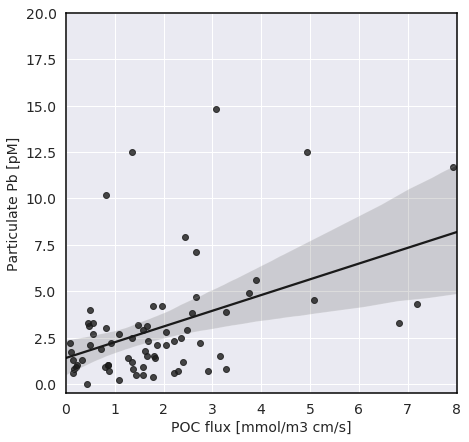

In [56]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
st = sns.axes_style("whitegrid")

with st:
    ax.set(ylim=(-0.5,20), xlim=(0,8.0))
    sns.regplot(POC_masked*1e5, pPb_masked, truncate=False, ax=ax, color='k')
    
    ax.set_ylabel('Particulate Pb [pM]', fontsize=14)
    ax.set_xlabel('POC flux [mmol/m3 cm/s]', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

POC drop metric:

In [38]:
pdepth_BB1 = np.array(pdepth_BB1); pdepth_BB2 = np.array(pdepth_BB2); pdepth_BB3 = np.array(pdepth_BB3);

pdepth_CB1 = np.array(pdepth_CB1); pdepth_CB2 = np.array(pdepth_CB2); pdepth_CB3 = np.array(pdepth_CB3);
pdepth_CB4 = np.array(pdepth_CB4); 

pdepth_CAA1 = np.array(pdepth_CAA1); pdepth_CAA2 = np.array(pdepth_CAA2); pdepth_CAA3 = np.array(pdepth_CAA3);
pdepth_CAA4 = np.array(pdepth_CAA4); pdepth_CAA5 = np.array(pdepth_CAA5); pdepth_CAA6 = np.array(pdepth_CAA6);
pdepth_CAA7 = np.array(pdepth_CAA7); pdepth_CAA8 = np.array(pdepth_CAA8); pdepth_CAA9 = np.array(pdepth_CAA9);

In [39]:
drop_BB1 = np.nanmean(pPb_BB1[pdepth_BB1 < 100]) - pPb_BB1[pdepth_BB1 > 100]; 
drop_BB2 = np.nanmean(pPb_BB2[pdepth_BB2 < 100]) - pPb_BB2[pdepth_BB2 > 100]; 
drop_BB3 = np.nanmean(pPb_BB3[pdepth_BB3 < 100]) - pPb_BB3[pdepth_BB3 > 100]; 
ddep_BB1 = pdepth_BB1[pdepth_BB1 > 100]; ddep_BB2 = pdepth_BB2[pdepth_BB2 > 100]; 
ddep_BB3 = pdepth_BB3[pdepth_BB3 > 100];

drop_CB1 = np.nanmean(pPb_CB1[pdepth_CB1 < 100]) - pPb_CB1[pdepth_CB1 > 100];
drop_CB2 = np.nanmean(pPb_CB2[pdepth_CB2 < 100]) - pPb_CB2[pdepth_CB2 > 100];
drop_CB3 = np.nanmean(pPb_CB3[pdepth_CB3 < 100]) - pPb_CB3[pdepth_CB3 > 100];
drop_CB4 = np.nanmean(pPb_CB4[pdepth_CB4 < 100]) - pPb_CB4[pdepth_CB4 > 100];
ddep_CB1 = pdepth_CB1[pdepth_CB1 > 100]; ddep_CB2 = pdepth_CB2[pdepth_CB2 > 100];
ddep_CB3 = pdepth_CB3[pdepth_CB3 > 100]; ddep_CB4 = pdepth_CB4[pdepth_CB4 > 100];

drop_CAA1 = np.nanmean(pPb_CAA1[pdepth_CAA1 < 100]) - pPb_CAA1[pdepth_CAA1 > 100];
drop_CAA2 = np.nanmean(pPb_CAA2[pdepth_CAA2 < 100]) - pPb_CAA2[pdepth_CAA2 > 100];
drop_CAA3 = np.nanmean(pPb_CAA3[pdepth_CAA3 < 100]) - pPb_CAA3[pdepth_CAA3 > 100];
drop_CAA4 = np.nanmean(pPb_CAA4[pdepth_CAA4 < 100]) - pPb_CAA4[pdepth_CAA4 > 100];
drop_CAA5 = np.nanmean(pPb_CAA5[pdepth_CAA5 < 100]) - pPb_CAA5[pdepth_CAA5 > 100];
drop_CAA6 = np.nanmean(pPb_CAA6[pdepth_CAA6 < 100]) - pPb_CAA6[pdepth_CAA6 > 100];
drop_CAA7 = np.nanmean(pPb_CAA7[pdepth_CAA7 < 100]) - pPb_CAA7[pdepth_CAA7 > 100];
drop_CAA8 = np.nanmean(pPb_CAA8[pdepth_CAA8 < 100]) - pPb_CAA8[pdepth_CAA8 > 100];
drop_CAA9 = np.nanmean(pPb_CAA9[pdepth_CAA9 < 100]) - pPb_CAA9[pdepth_CAA9 > 100];
ddep_CAA1 = pdepth_CAA1[pdepth_CAA1 > 100]; ddep_CAA2 = pdepth_CAA2[pdepth_CAA2 > 100];
ddep_CAA3 = pdepth_CAA3[pdepth_CAA3 > 100]; ddep_CAA4 = pdepth_CAA4[pdepth_CAA4 > 100];
ddep_CAA5 = pdepth_CAA5[pdepth_CAA5 > 100]; ddep_CAA6 = pdepth_CAA6[pdepth_CAA6 > 100];
ddep_CAA7 = pdepth_CAA7[pdepth_CAA7 > 100]; ddep_CAA8 = pdepth_CAA8[pdepth_CAA8 > 100];
ddep_CAA9 = pdepth_CAA9[pdepth_CAA9 > 100];

drop_Pb = np.concatenate((drop_BB1, drop_BB2, drop_BB3, drop_CAA1, drop_CAA2, drop_CAA3, drop_CAA4, \
                      drop_CAA5, drop_CAA6, drop_CAA7, drop_CAA8, drop_CAA9, drop_CB1, drop_CB2, \
                      drop_CB3, drop_CB4))

drop_pdepth = np.concatenate((pdepth_BB1[pdepth_BB1 > 100], pdepth_BB2[pdepth_BB2 > 100], pdepth_BB3[pdepth_BB3 > 100], \
                              pdepth_CAA1[pdepth_CAA1 > 100], pdepth_CAA2[pdepth_CAA2 > 100], pdepth_CAA3[pdepth_CAA3 > 100], \
                              pdepth_CAA4[pdepth_CAA4 > 100], pdepth_CAA5[pdepth_CAA5 > 100], pdepth_CAA6[pdepth_CAA6 > 100], \
                              pdepth_CAA7[pdepth_CAA7 > 100], pdepth_CAA8[pdepth_CAA8 > 100], pdepth_CAA9[pdepth_CAA9 > 100], \
                              pdepth_CB1[pdepth_CB1 > 100], pdepth_CB2[pdepth_CB2 > 100], pdepth_CB3[pdepth_CB3 > 100], \
                              pdepth_CB4[pdepth_CB4 > 100]))

In [41]:
drop_lons = np.concatenate((np.ones(pdepth_BB1[pdepth_BB1 > 100].shape)*lons[stn_names=='BB1'], \
                          np.ones(pdepth_BB2[pdepth_BB2 > 100].shape)*lons[stn_names=='BB2'], \
                          np.ones(pdepth_BB3[pdepth_BB3 > 100].shape)*lons[stn_names=='BB3'], \
                          np.ones(pdepth_CAA1[pdepth_CAA1 > 100].shape)*lons[stn_names=='CAA1'], \
                          np.ones(pdepth_CAA2[pdepth_CAA2 > 100].shape)*lons[stn_names=='CAA2'], \
                          np.ones(pdepth_CAA3[pdepth_CAA3 > 100].shape)*lons[stn_names=='CAA3'], \
                          np.ones(pdepth_CAA4[pdepth_CAA4 > 100].shape)*lons[stn_names=='CAA4'], \
                          np.ones(pdepth_CAA5[pdepth_CAA5 > 100].shape)*lons[stn_names=='CAA5'], \
                          np.ones(pdepth_CAA6[pdepth_CAA6 > 100].shape)*lons[stn_names=='CAA6'], \
                          np.ones(pdepth_CAA7[pdepth_CAA7 > 100].shape)*lons[stn_names=='CAA7'], \
                          np.ones(pdepth_CAA8[pdepth_CAA8 > 100].shape)*lons[stn_names=='CAA8'], \
                          np.ones(pdepth_CAA9[pdepth_CAA9 > 100].shape)*lons[stn_names=='CAA9'], \
                          np.ones(pdepth_CB1[pdepth_CB1 > 100].shape)*lons[stn_names=='CB1'], \
                          np.ones(pdepth_CB2[pdepth_CB2 > 100].shape)*lons[stn_names=='CB2'], \
                          np.ones(pdepth_CB3[pdepth_CB3 > 100].shape)*lons[stn_names=='CB3'], \
                          np.ones(pdepth_CB4[pdepth_CB4 > 100].shape)*lons[stn_names=='CB4']))

drop_lats = np.concatenate((np.ones(pdepth_BB1[pdepth_BB1 > 100].shape)*lats[stn_names=='BB1'], \
                          np.ones(pdepth_BB2[pdepth_BB2 > 100].shape)*lats[stn_names=='BB2'], \
                          np.ones(pdepth_BB3[pdepth_BB3 > 100].shape)*lats[stn_names=='BB3'], \
                          np.ones(pdepth_CAA1[pdepth_CAA1 > 100].shape)*lats[stn_names=='CAA1'], \
                          np.ones(pdepth_CAA2[pdepth_CAA2 > 100].shape)*lats[stn_names=='CAA2'], \
                          np.ones(pdepth_CAA3[pdepth_CAA3 > 100].shape)*lats[stn_names=='CAA3'], \
                          np.ones(pdepth_CAA4[pdepth_CAA4 > 100].shape)*lats[stn_names=='CAA4'], \
                          np.ones(pdepth_CAA5[pdepth_CAA5 > 100].shape)*lats[stn_names=='CAA5'], \
                          np.ones(pdepth_CAA6[pdepth_CAA6 > 100].shape)*lats[stn_names=='CAA6'], \
                          np.ones(pdepth_CAA7[pdepth_CAA7 > 100].shape)*lats[stn_names=='CAA7'], \
                          np.ones(pdepth_CAA8[pdepth_CAA8 > 100].shape)*lats[stn_names=='CAA8'], \
                          np.ones(pdepth_CAA9[pdepth_CAA9 > 100].shape)*lats[stn_names=='CAA9'], \
                          np.ones(pdepth_CB1[pdepth_CB1 > 100].shape)*lats[stn_names=='CB1'], \
                          np.ones(pdepth_CB2[pdepth_CB2 > 100].shape)*lats[stn_names=='CB2'], \
                          np.ones(pdepth_CB3[pdepth_CB3 > 100].shape)*lats[stn_names=='CB3'], \
                          np.ones(pdepth_CB4[pdepth_CB4 > 100].shape)*lats[stn_names=='CB4']))

In [42]:
# Find corresponding lons at lats for POC flux compared to the station locations:

i_stn_drop = []; j_stn_drop = [];
for stn in range(0,len(drop_lons)):
    i, j = ar.find_closest_model_point(360+drop_lons[stn], drop_lats[stn], POC_lon, POC_lat, \
                                       tols={'NEMO': {'tol_lon': 0.5, 'tol_lat': 0.5}})
    i_stn_drop.append(i)
    j_stn_drop.append(j)
    
i_POC_drop = np.array(i_stn_drop)
j_POC_drop = np.array(j_stn_drop)

In [44]:
POC_drop_depths, POC_drop_z_index = assoc_depth(drop_pdepth)

In [46]:
POC_array_drop = []

for ind in range(0,len(drop_pdepth)):
    try:
#         print(POC_z_index[ind], i_POC[ind], j_POC[ind])
        POC_flx = POC_flux[191, int(POC_drop_z_index[ind]), i_POC_drop[ind], j_POC_drop[ind]]
    except:
        POC_flx = np.nan
        
    POC_array_drop.append(POC_flx)
    
POC_flux_stns_drop = np.array(POC_array_drop)

POC_flux_stns_drop[POC_flux_stns_drop > 1e10] = np.nan
POC_flux_stns_drop[POC_flux_stns_drop == 0.0] = np.nan

In [52]:
# Mask places where depths are too different:

pPb_drop_masked = np.ma.masked_where(np.logical_or(np.isnan(POC_flux_stns_drop), np.isnan(drop_Pb)), drop_Pb)
POC_drop_masked = np.ma.masked_where(np.logical_or(np.isnan(POC_flux_stns_drop), np.isnan(drop_Pb)), POC_flux_stns_drop)

In [53]:
print(np.ma.max(pPb_drop_masked), np.ma.max(POC_drop_masked))

5.18 7.932126027299091e-05


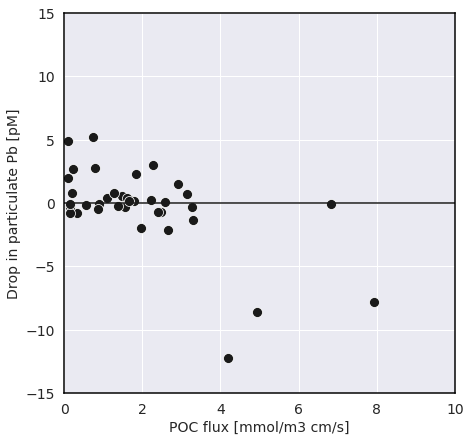

In [55]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
st = sns.axes_style("whitegrid")

with st:
#     sns.lineplot(xp, yp_pred, c='k')
    sns.scatterplot(POC_drop_masked*1e5, pPb_drop_masked, color='k', s=100)
    sns.lineplot([0, 100], [0, 0], c='k')
    
    ax.set_ylabel('Drop in particulate Pb [pM]', fontsize=14)
    ax.set_xlabel('POC flux [mmol/m3 cm/s]', fontsize=14)
    ax.set(ylim=(-15,15), xlim=(0,10.0))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

### Attempts that failed:

POC flux versus dissolved Pb decrease. Where POC flux is high, I expect dissolved Pb to be removed rapidly, so to decrease strongly with depth.

In [94]:
def calc_deriv(dPb, depth, visualize=False):
    
    dPb   = np.array(dPb)
    depth = np.array(depth)
    
    # smooth the array:
    dPb_smooth = savgol_filter(dPb, 9, 3)

    if visualize:
        fig, ax = plt.subplots(1,1,figsize=(4,6))
        ax.invert_yaxis()
        ax.scatter(dPb, depth, label='original')
        ax.scatter(dPb_smooth, depth, label='smoothed')
        ax.legend()
    
    # calculate the derivative:    
    deriv = [(dPb_smooth[i+1] - dPb_smooth[i])/(depth[i+1] - depth[i]) for i in range(0,len(dPb)-1)]
    
    # add NaN as the last element so that the array length is equal to the rest
    deriv.append(np.nan) 
    
    return np.array(deriv)

In [95]:
# Calculate Pb drop with depth:
d_BB1 = calc_deriv(dPb_BB1, depth_BB1); d_BB2 = calc_deriv(dPb_BB2, depth_BB2); 
d_BB3 = calc_deriv(dPb_BB3, depth_BB3); d_CB1 = calc_deriv(dPb_CB1, depth_CB1);
d_CB2 = calc_deriv(dPb_CB2, depth_CB2); d_CB3 = calc_deriv(dPb_CB3, depth_CB3);
d_CB4 = calc_deriv(dPb_CB4, depth_CB4); d_CAA1 = calc_deriv(dPb_CAA1, depth_CAA1);
d_CAA2 = calc_deriv(dPb_CAA2, depth_CAA2); d_CAA3 = calc_deriv(dPb_CAA3, depth_CAA3);
d_CAA4 = calc_deriv(dPb_CAA4, depth_CAA4); d_CAA5 = calc_deriv(dPb_CAA5, depth_CAA5);
d_CAA6 = calc_deriv(dPb_CAA6, depth_CAA6); d_CAA7 = calc_deriv(dPb_CAA7, depth_CAA7);
d_CAA8 = calc_deriv(dPb_CAA8, depth_CAA8); d_CAA9 = calc_deriv(dPb_CAA9, depth_CAA9);

# Combine all observations into single collapsed arrays:
obs_d_dPb = np.concatenate((d_BB1, d_BB2, d_BB3, d_CAA1, d_CAA2, d_CAA3, d_CAA4, \
                            d_CAA5, d_CAA6, d_CAA7, d_CAA8, d_CAA9, d_CB1, d_CB2, \
                            d_CB3, d_CB4))

obs_d_dPb[np.isinf(np.abs(obs_d_dPb))] = np.nan

In [96]:
# Mask places where depths are too different:
d_dPb_masked = np.ma.masked_where(np.logical_or(np.isnan(POC_flux_stns), np.isnan(obs_d_dPb)), obs_d_dPb)
POC_masked   = np.ma.masked_where(np.logical_or(np.isnan(POC_flux_stns), np.isnan(obs_d_dPb)), POC_flux_stns)

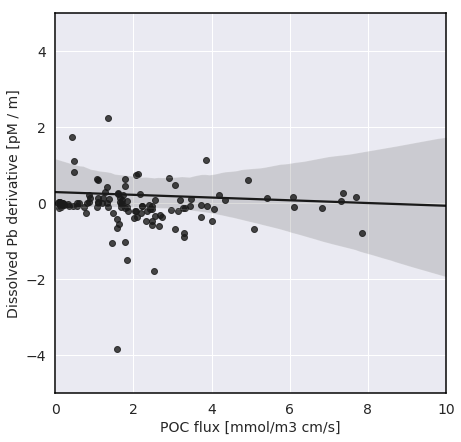

In [100]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
st = sns.axes_style("whitegrid")

with st:
    ax.set(ylim=(-5,5), xlim=(0,10.0))
    sns.regplot(POC_masked*1e5, d_dPb_masked*1e4, truncate=False, ax=ax, color='k')
#     ax = sns.scatterplot(POC_masked*1e5, dPb_masked*1e3, color='k', s=100)
    
    ax.set_ylabel('Dissolved Pb derivative [pM / m]', fontsize=14)
    ax.set_xlabel('POC flux [mmol/m3 cm/s]', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    